<a href="https://colab.research.google.com/github/madhurima1107/my-first-task/blob/main/GRN_individual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title ── 1. Install & Import Dependencies
!pip install xlrd pandas numpy scipy scikit-learn statsmodels networkx matplotlib tqdm

import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.neighbors import KernelDensity
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import files
import warnings
warnings.filterwarnings('ignore')


In [2]:
#@title ── 2. Upload & Inspect Your Data
uploaded = files.upload()  # select GSE118657.xlsx
fname = next(iter(uploaded.keys()))
print("Loaded file:", fname)

# Load the single sheet
df = pd.read_excel(fname, header=0, index_col=0)
print("Full data shape (genes × all samples):", df.shape)
df.iloc[:5, :5]


Saving GSE118657.xlsx to GSE118657 (1).xlsx
Loaded file: GSE118657 (1).xlsx
Full data shape (genes × all samples): (49495, 209)


,patient 30 Day.1,patient 31 Day.21,patient 33 Day.1,patient 33 Day.7,patient 33 Day.14
!Sample_title,,,,,
11715100_at,5.904133,6.294314,5.950343,6.384133,6.499386
11715101_s_at,9.110374,8.848973,9.035442,9.193757,9.025636
11715102_x_at,8.131026,8.177420,7.994334,8.298096,8.450822
11715103_x_at,6.753193,7.050433,6.754935,6.951082,7.152262
11715104_s_at,6.481610,6.811767,6.603700,6.730390,7.044547


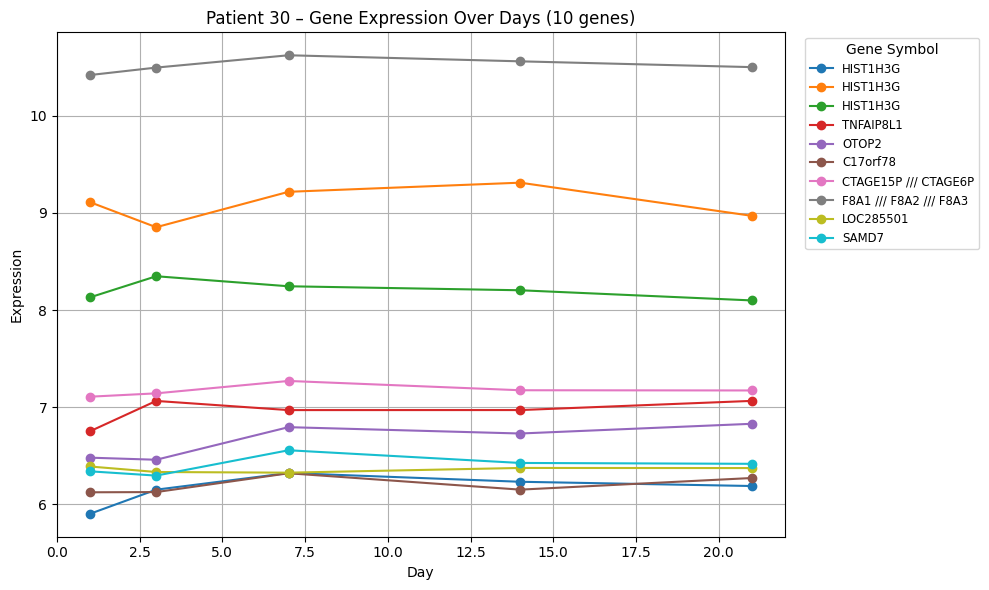

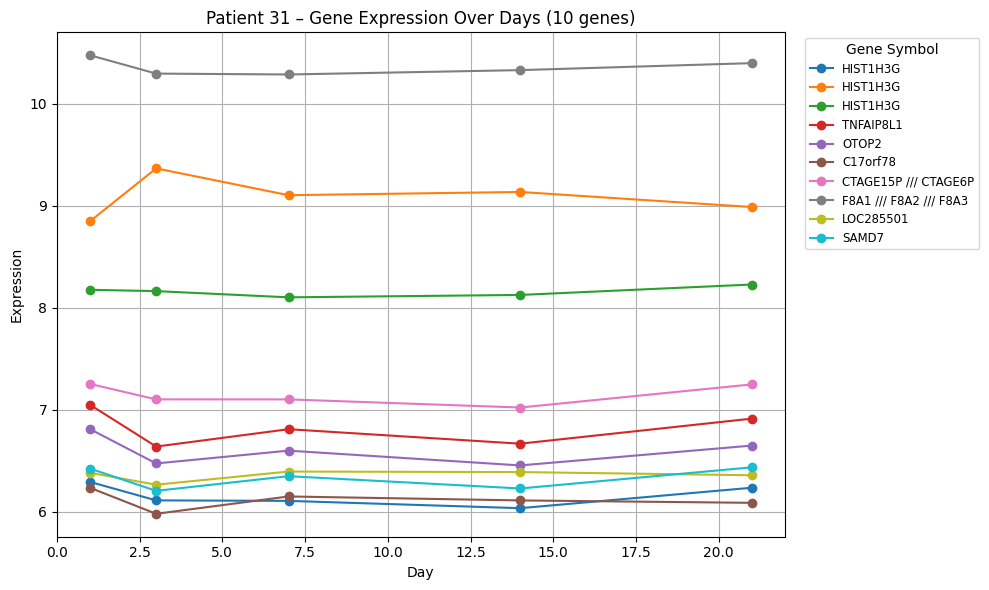

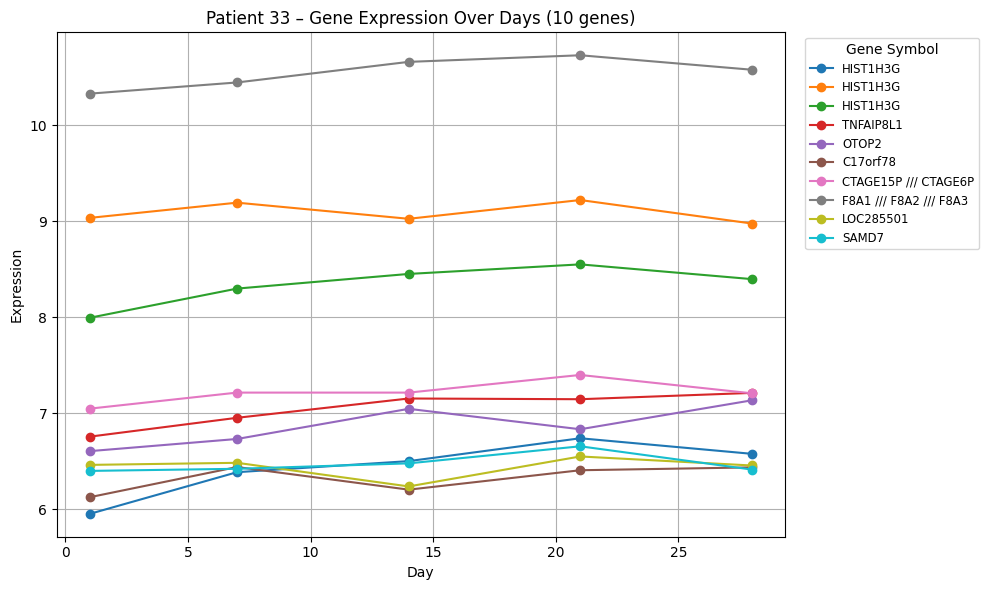

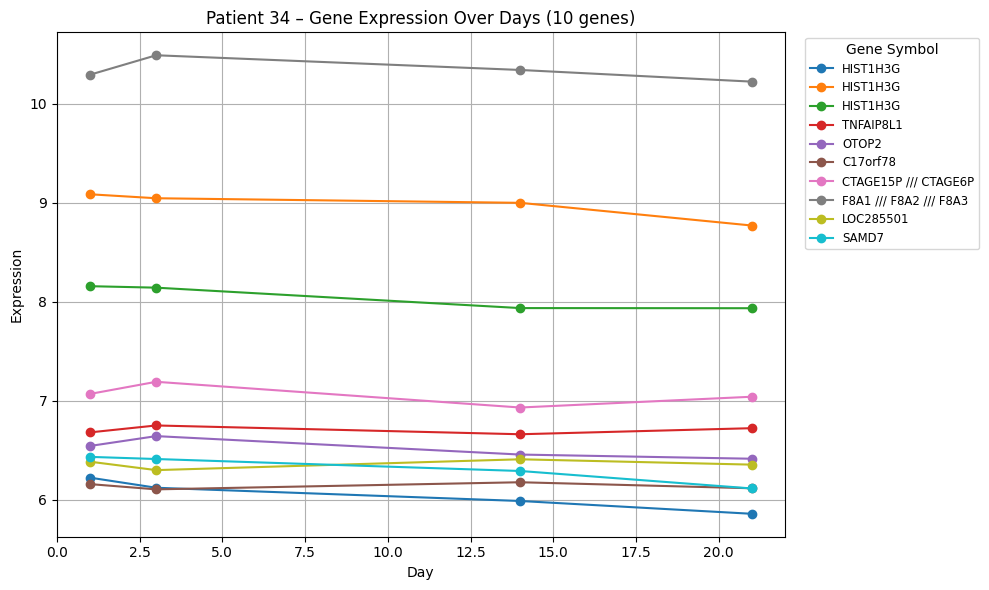

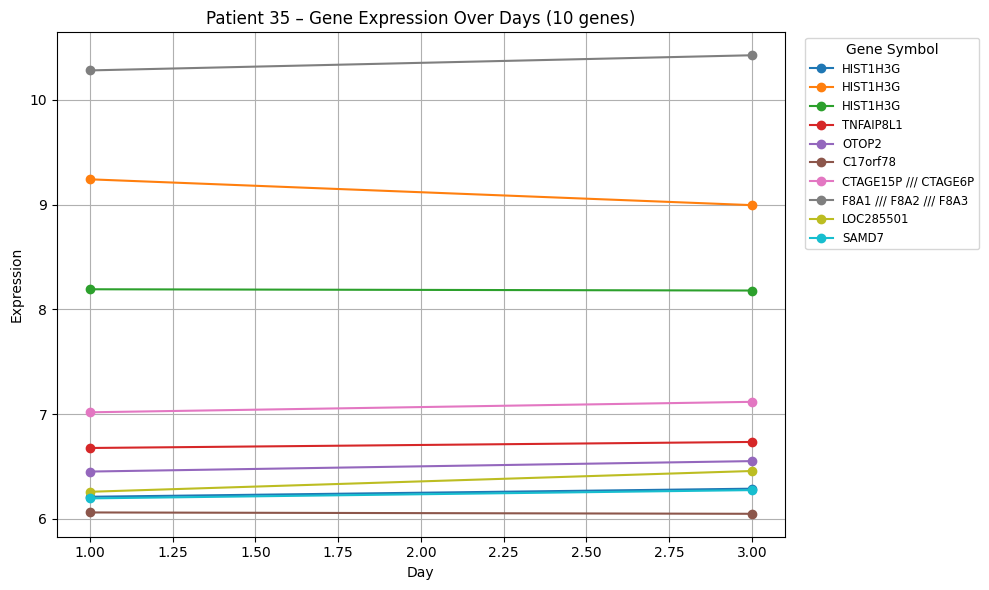

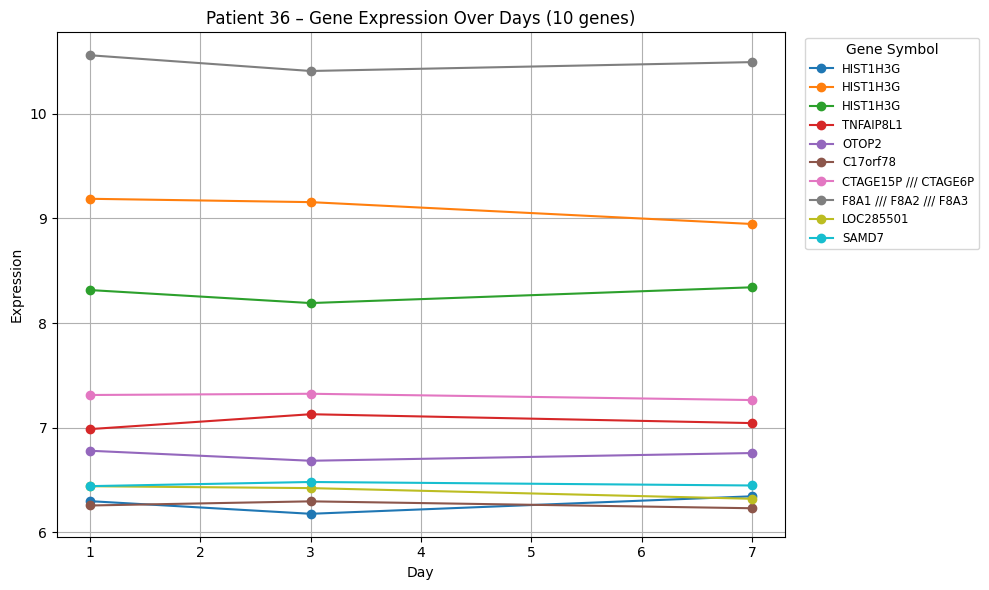

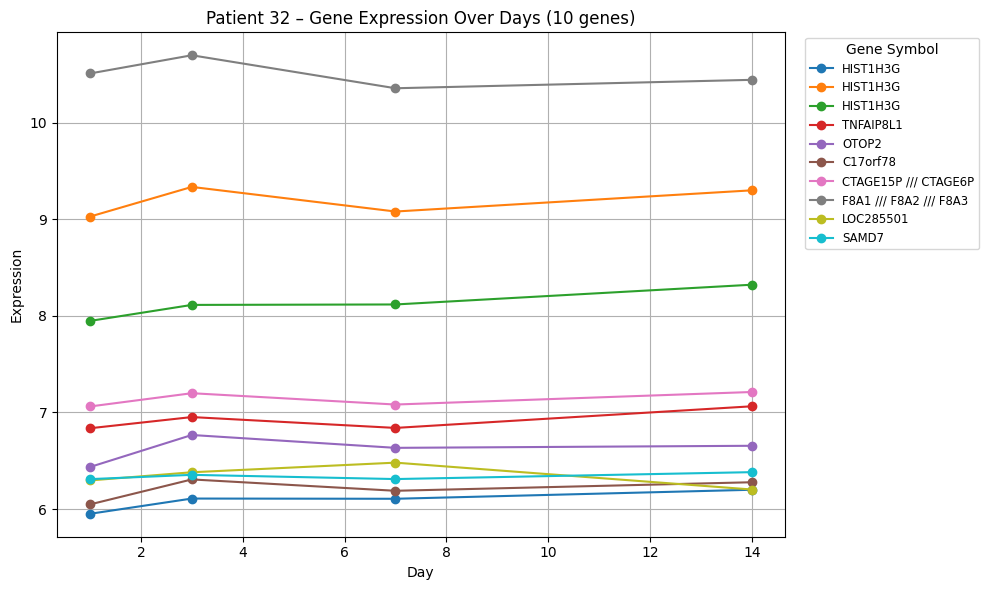

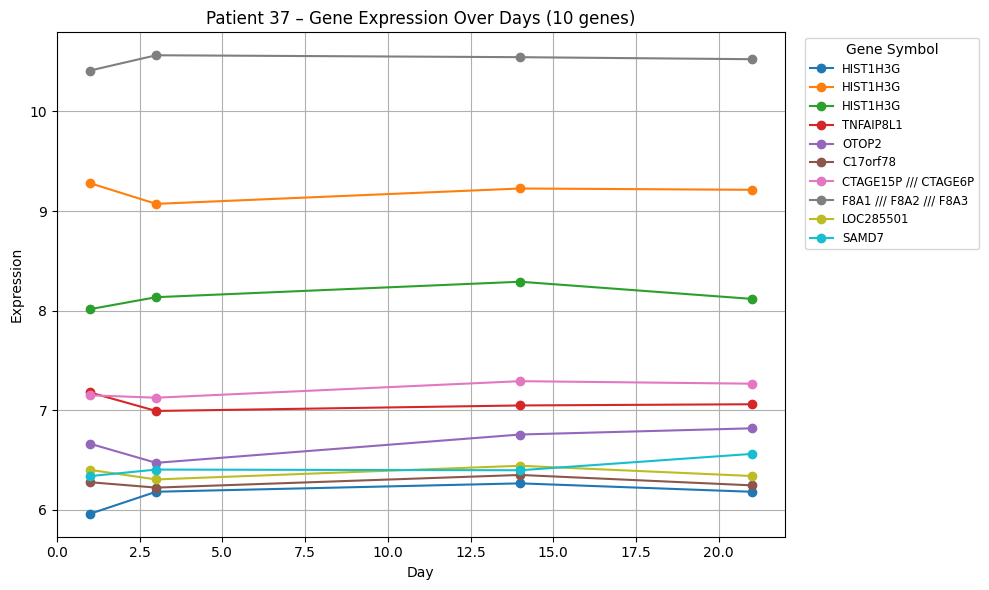

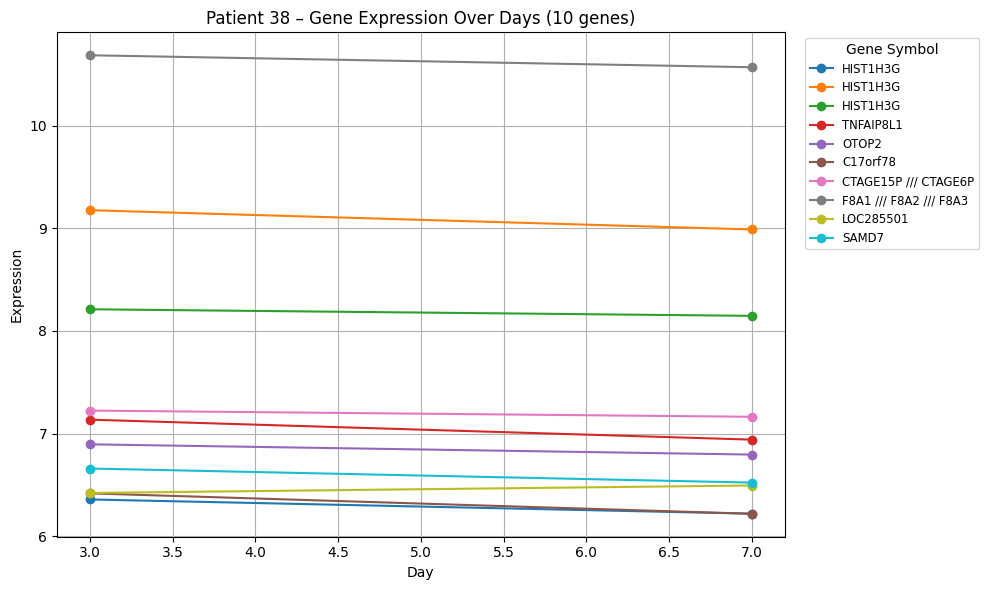

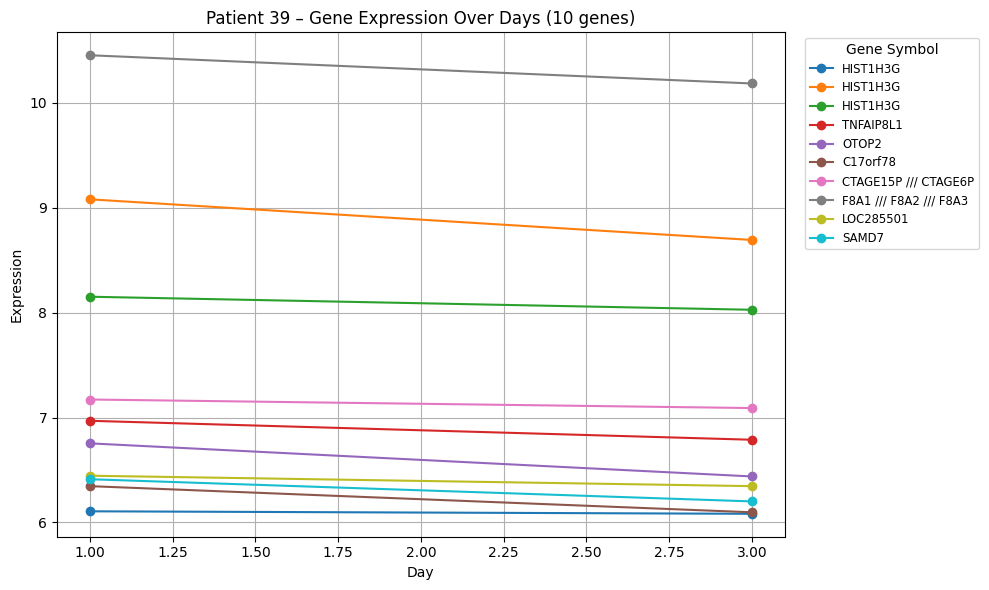

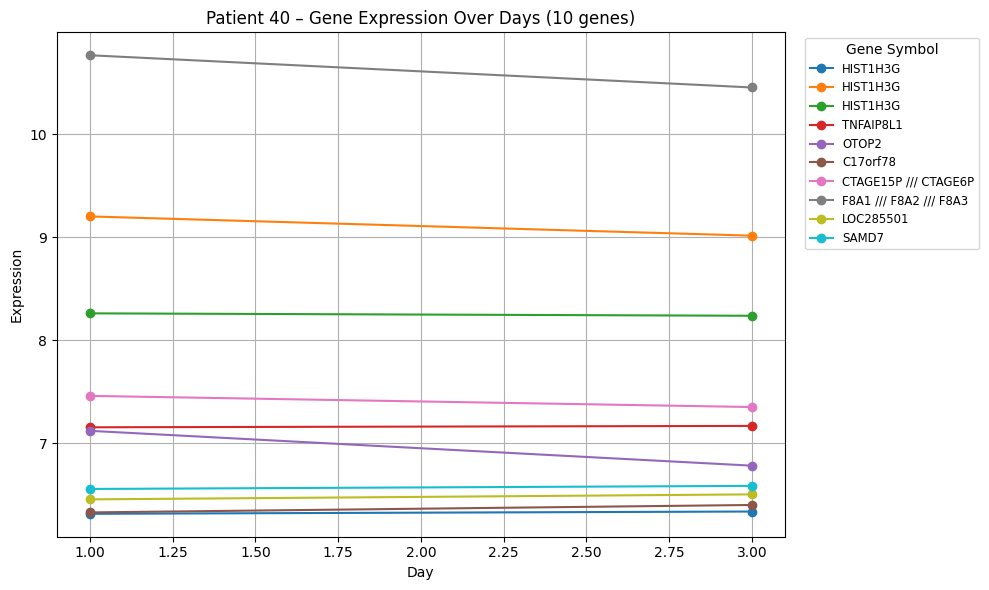

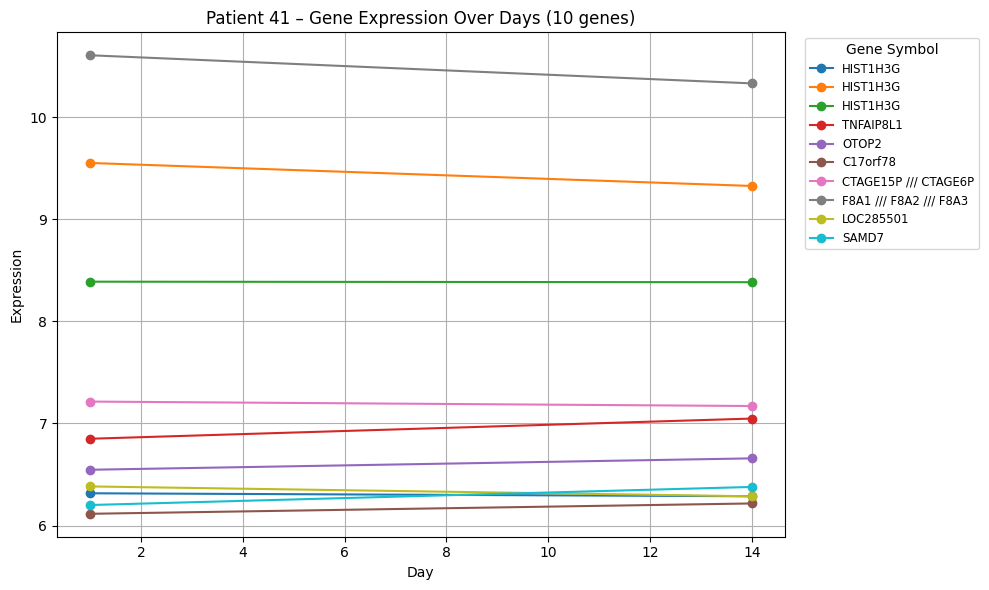

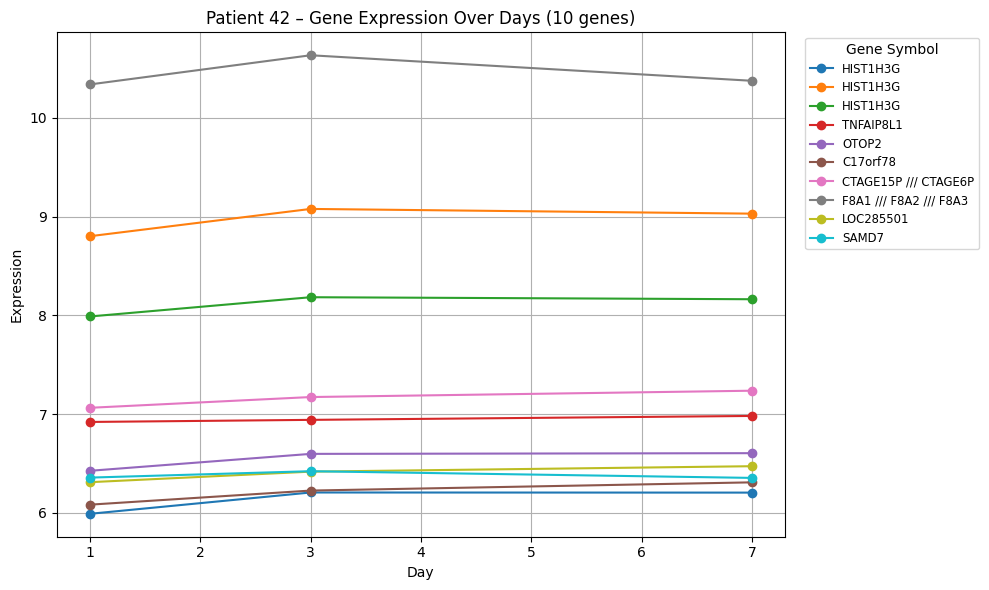

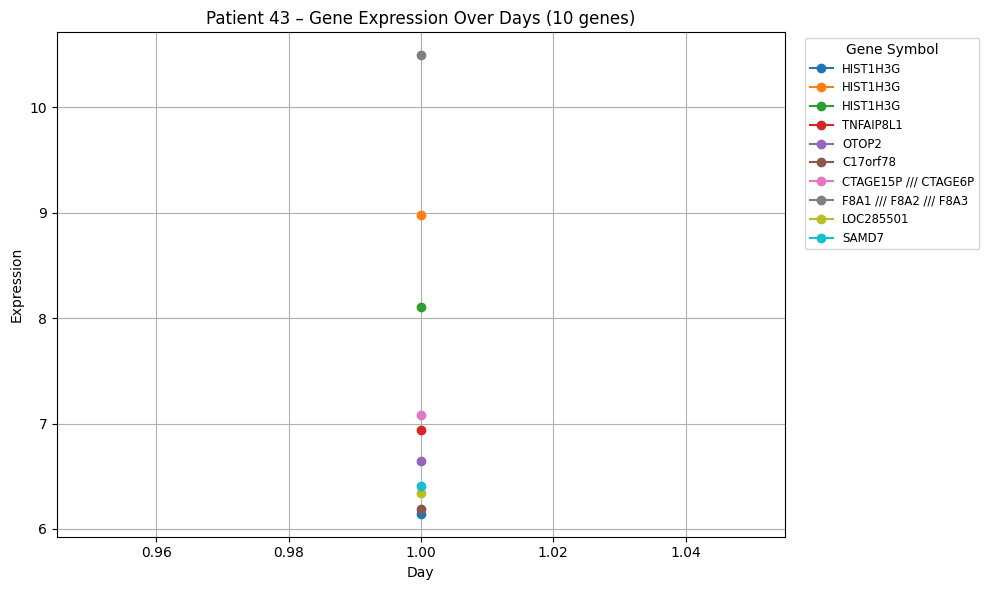

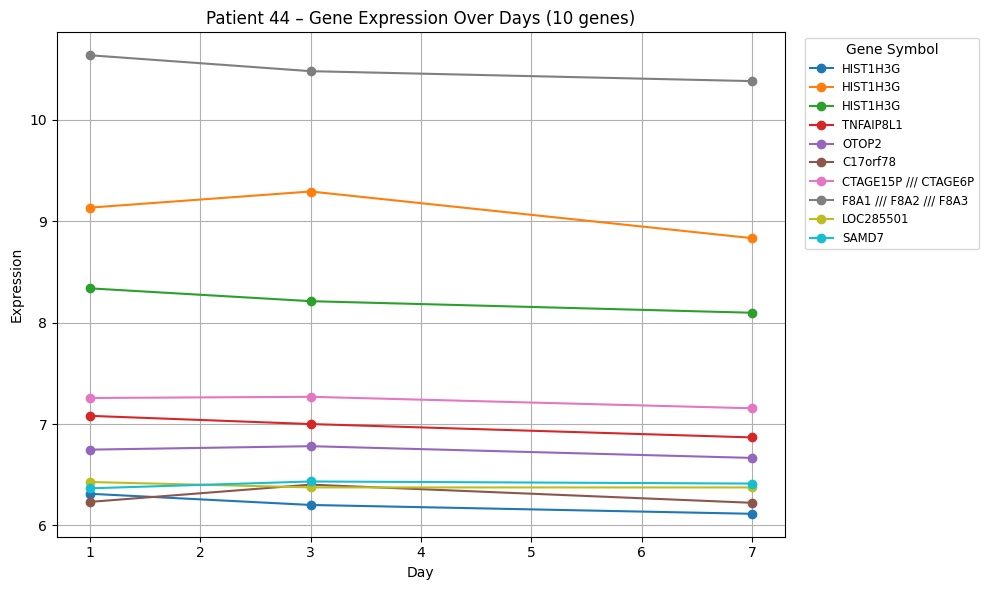

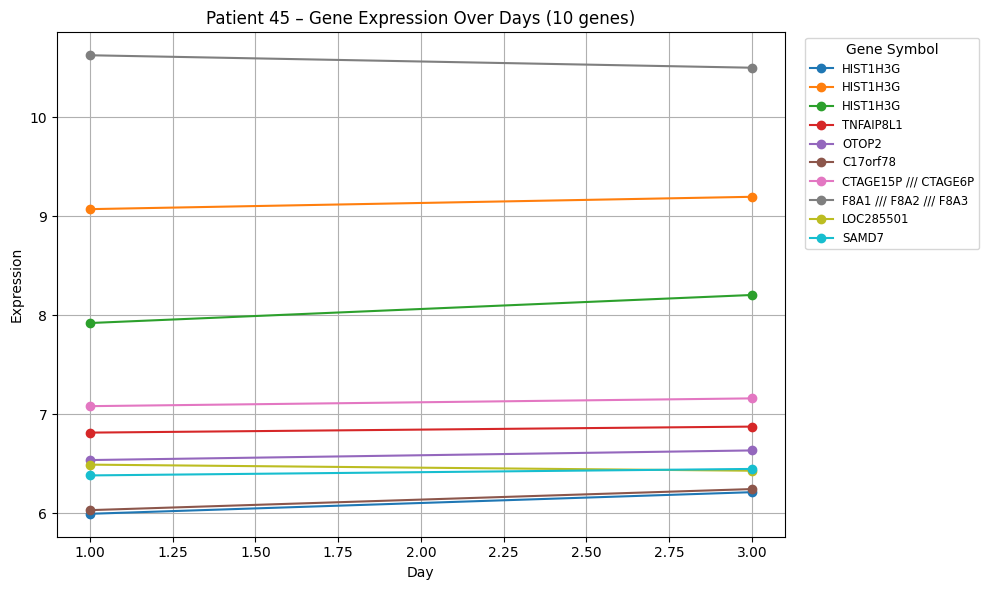

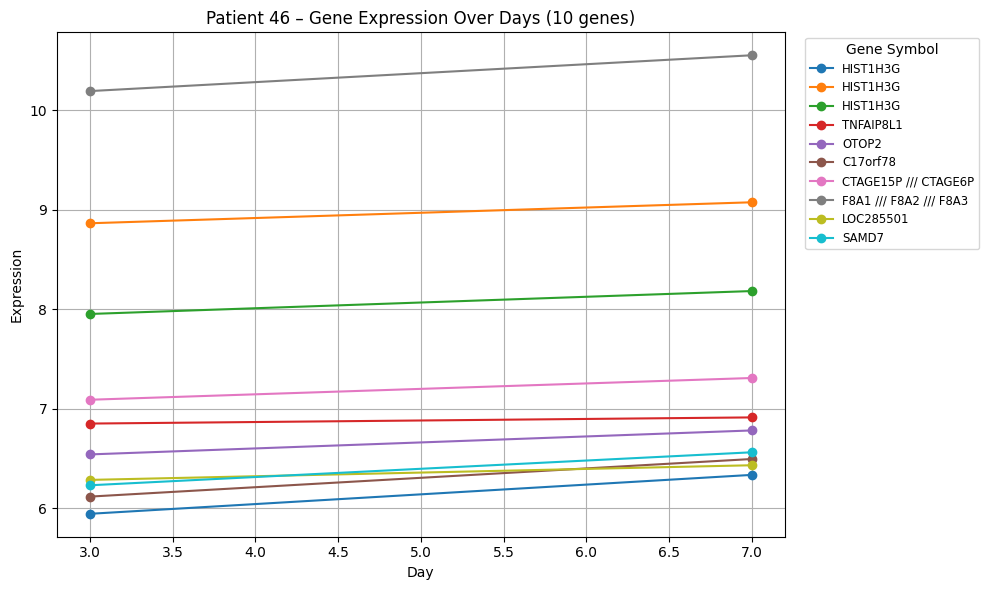

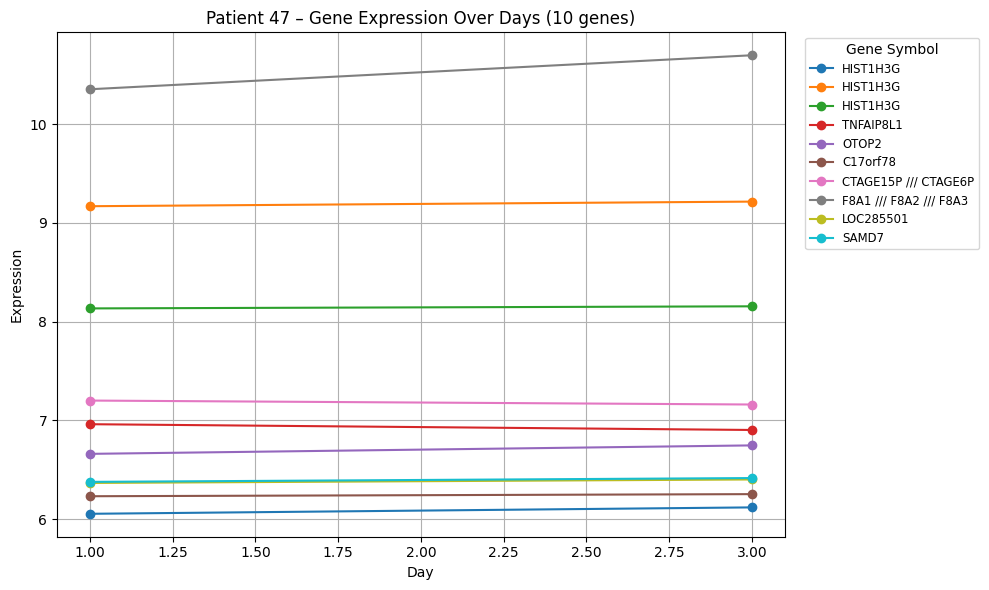

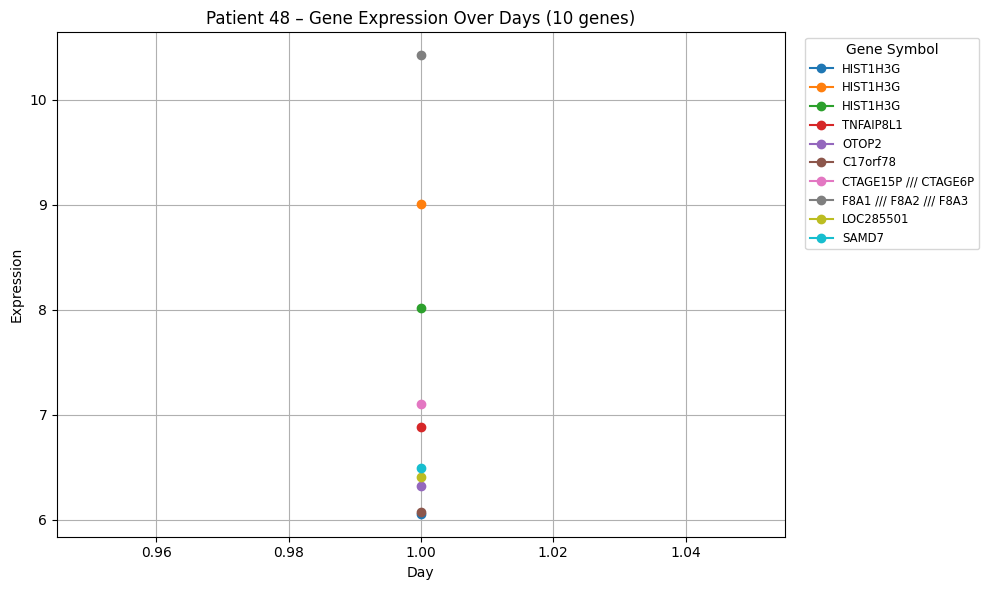

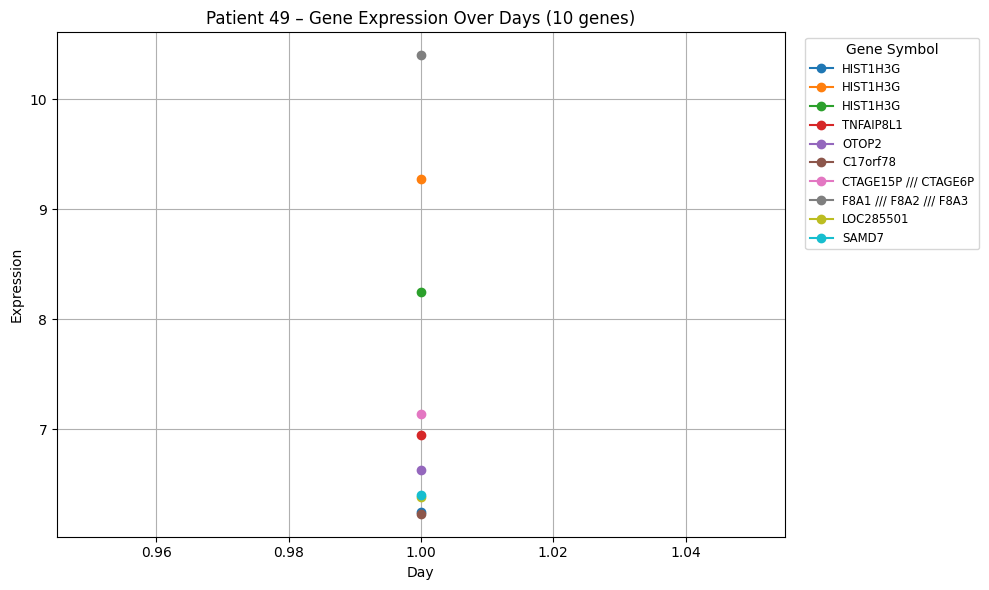

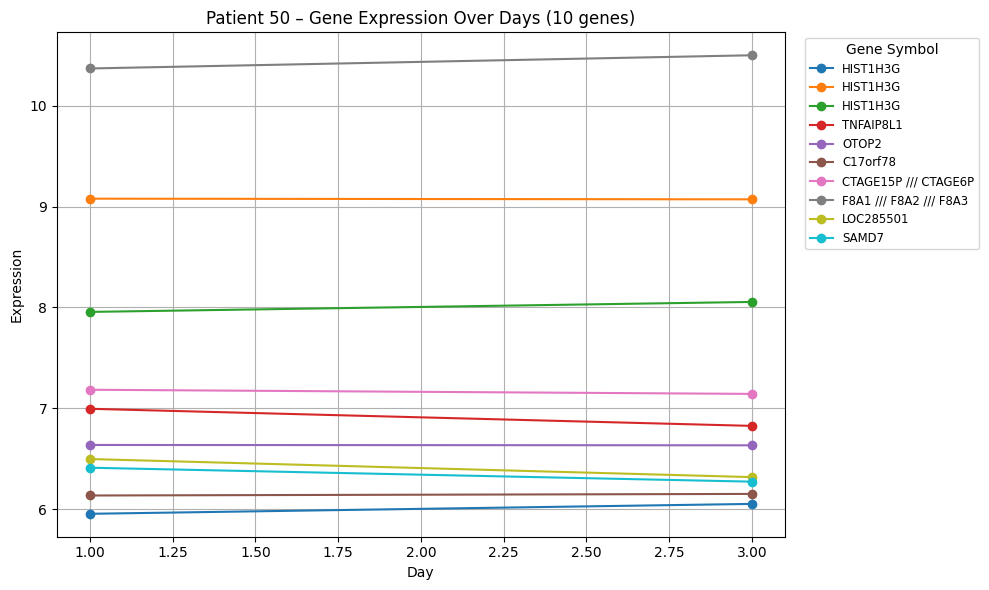

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# File paths
expr_file  = "/content/GSE118657.xlsx"
annot_file = "/content/GSE118657_Family.xlsx"

# 1. Load annotation → mapping probe ID → gene symbol
ann = pd.read_excel(annot_file, header=0)
probe_col     = ann.columns[0]
symbol_cols   = [c for c in ann.columns if "symbol" in c.lower()]
symbol_col    = symbol_cols[0] if symbol_cols else ann.columns[1]
probe2symbol  = dict(zip(ann[probe_col], ann[symbol_col]))

# 2. Read only headers of the expression file
df_cols     = pd.read_excel(expr_file, header=0, nrows=0)
all_columns = df_cols.columns.tolist()

# 3. Parse patient and day from each column name
def extract_patient_day(col):
    m = re.match(r"patient (\d+) Day\.(\d+)", col)
    if m: return m.group(1), int(m.group(2))
    return None, None

col_info = [
    (col, *extract_patient_day(col))
    for col in all_columns
    if extract_patient_day(col)[0] is not None
]
col_df = pd.DataFrame(col_info, columns=["column","patient","day"])
patients = col_df["patient"].unique()

# 4. Plot per patient using only their columns
N_GENES = 10  # plot top 10 probes → symbols

for pid in patients:
    tmp = col_df[col_df["patient"] == pid].sort_values("day")
    cols = tmp["column"].tolist()
    days = tmp["day"].values

    # read only these columns + index
    usecols = ["!Sample_title"] + cols
    df_pt   = pd.read_excel(expr_file, header=0, index_col=0, usecols=usecols)

    top_probes  = df_pt.index[:N_GENES]
    symbols     = [probe2symbol.get(p, p) for p in top_probes]

    plt.figure(figsize=(10,6))
    for probe, sym in zip(top_probes, symbols):
        plt.plot(days, df_pt.loc[probe].values, marker="o", label=sym)

    plt.title (f"Patient {pid} – Gene Expression Over Days ({N_GENES} genes)")
    plt.xlabel("Day")
    plt.ylabel("Expression")
    plt.legend(loc="upper left", bbox_to_anchor=(1.02,1.0), title="Gene Symbol", fontsize="small")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [3]:
#@title ── 3. Extract One Patient’s Time-Series (≈ 82 columns)
patient_id = "patient 30"  # ← change as needed
# keep any column whose name starts with “patient 30 ”
dfp = df.loc[:, df.columns.str.startswith(patient_id)]
print(f"{patient_id} data shape:", dfp.shape)
dfp.iloc[:5, :5]


patient 30 data shape: (49495, 5)


,patient 30 Day.1,patient 30 Day.3,patient 30 Day.7,patient 30 Day.14,patient 30 Day.21
!Sample_title,,,,,
11715100_at,5.904133,6.152304,6.323664,6.233688,6.189921
11715101_s_at,9.110374,8.852664,9.217049,9.310977,8.969851
11715102_x_at,8.131026,8.348279,8.245100,8.203955,8.099457
11715103_x_at,6.753193,7.065448,6.971111,6.971426,7.065773
11715104_s_at,6.481610,6.460158,6.795438,6.730195,6.830202


In [5]:
#@title ── 4. Normalize Expression (log₂ + z-score per gene)
df_log  = np.log2(dfp + 1)
df_norm = df_log.sub(df_log.mean(axis=1), axis=0).div(df_log.std(axis=1), axis=0)
print("Normalized shape:", df_norm.shape)


Normalized shape: (49495, 5)


In [6]:
#@title ── 5. Find Top 10 Time-Responsive Genes by OLS Regression
def find_top_genes(expr_df, top_k=10):
    # assume columns like “patient 30 Day.1”, “patient 30 Day.3”, … extract the day #
    time_points = [int(c.split("Day.")[-1]) for c in expr_df.columns]
    X = sm.add_constant(time_points)
    results = []
    for gene in expr_df.index:
        y = expr_df.loc[gene].values
        model = sm.OLS(y, X).fit()
        results.append((gene, model.pvalues[1], model.params[1]))
    res = pd.DataFrame(results, columns=['Gene','pval','slope']).sort_values('pval')
    return res.head(top_k)

sig_df = find_top_genes(df_norm, top_k=10)
print("Top 10 genes:\n", sig_df)


Top 10 genes:
                 Gene      pval     slope
7449   11722549_a_at  0.000009 -0.121043
3078   11718178_a_at  0.000053 -0.120939
11728  11726828_x_at  0.000054  0.120936
44690    11759790_at  0.000163  0.120770
28219  11743319_a_at  0.000174  0.120755
30089  11745189_a_at  0.000226  0.120692
36663  11751763_a_at  0.000283  0.120628
38580  11753680_x_at  0.000345  0.120562
25874  11740974_a_at  0.000358 -0.120550
47844    11762944_at  0.000426 -0.120482


In [7]:
#@title ── 6. Subset to Those 10 Genes → 10 × 82 Matrix
top_genes = sig_df['Gene'].tolist()
data_10x82 = df_norm.loc[top_genes].T.values
print("Data for ARACNE:", data_10x82.shape, "(time × genes)")


Data for ARACNE: (5, 10) (time × genes)


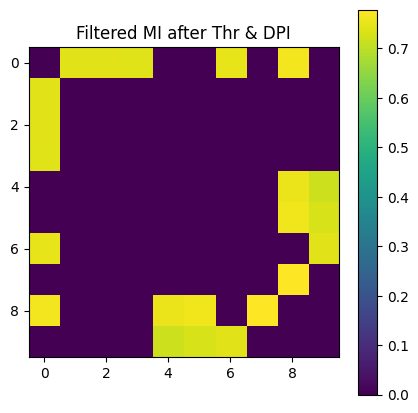

In [8]:
#@title ── 7. ARACNE-Style Inference (MI → Threshold → DPI)
def kernel_mi(x, y, bw=0.5):
    xy = np.vstack([x, y]).T
    kde_xy = KernelDensity(bandwidth=bw).fit(xy)
    logp_xy = kde_xy.score_samples(xy)
    logp_x  = KernelDensity(bandwidth=bw).fit(x[:,None]).score_samples(x[:,None])
    logp_y  = KernelDensity(bandwidth=bw).fit(y[:,None]).score_samples(y[:,None])
    return np.mean(logp_xy - logp_x - logp_y)

def infer_aracne(data, bw=0.5, n_perm=3):
    G = data.shape[1]
    M = np.zeros((G,G))
    # 1) compute MI matrix
    for i in range(G):
        for j in range(i+1, G):
            m = kernel_mi(data[:,i], data[:,j], bw=bw)
            M[i,j] = M[j,i] = m
    # 2) threshold I0 via permutations
    max_vals = []
    for _ in range(n_perm):
        sh = data.copy()
        for g in range(G): np.random.shuffle(sh[:,g])
        vs = [kernel_mi(sh[:,i], sh[:,j], bw)
              for i in range(G) for j in range(i+1, G)]
        max_vals.append(max(vs))
    I0 = np.mean(max_vals)
    M[M < I0] = 0
    # 3) apply DPI
    for i in range(G):
        for j in range(G):
            if M[i,j] <= 0: continue
            for k in range(G):
                if k in (i,j) or M[i,k] <= 0 or M[j,k] <= 0: continue
                trio = [(i,j,M[i,j]), (i,k,M[i,k]), (j,k,M[j,k])]
                a,b,_ = min(trio, key=lambda x: x[2])
                M[a,b] = M[b,a] = 0
    return M

mi_mat = infer_aracne(data_10x82, bw=0.5, n_perm=3)
plt.figure(figsize=(5,5))
plt.imshow(mi_mat, cmap='viridis')
plt.title("Filtered MI after Thr & DPI")
plt.colorbar()
plt.show()


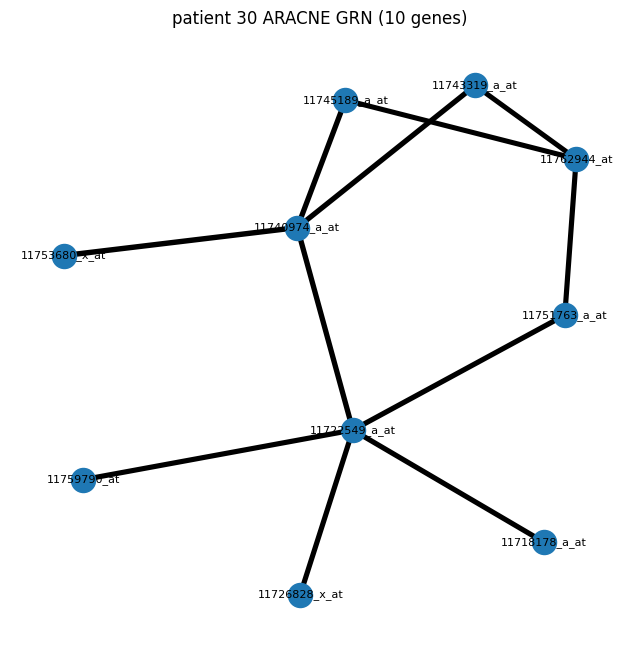

In [9]:
#@title ── 8. Build & Plot the GRN (10 nodes)
Gnet = nx.Graph()
Gnet.add_nodes_from(top_genes)
for i, g1 in enumerate(top_genes):
    for j, g2 in enumerate(top_genes):
        if j <= i: continue
        w = mi_mat[i,j]
        if w > 0:
            Gnet.add_edge(g1, g2, weight=w)

plt.figure(figsize=(8,8))
pos = nx.spring_layout(Gnet, k=0.5, seed=42)
nx.draw_networkx_nodes(Gnet, pos, node_size=300)
nx.draw_networkx_edges(
    Gnet, pos,
    width=[d['weight']*5 for _,_,d in Gnet.edges(data=True)]
)
nx.draw_networkx_labels(Gnet, pos, font_size=8)
plt.title(f"{patient_id} ARACNE GRN (10 genes)")
plt.axis('off')
plt.show()
